In [4]:
# imports
import numpy as np
from keras.datasets import fashion_mnist
from tqdm import tqdm
import wandb

In [15]:
# All functions required

# Activation functions
# 1 Relu
def relu(a):
    return np.max(a,0)

def relu_vector_old(a):
    temp = []
    for i in range(len(a)):
        temp.append(relu(a[i]))
    return temp

def relu_vector(a):
    return np.maximum(a,0)


# 2 Sigmoid
def sigmoid(a):
    ans = 1/(1+np.exp(-a))
    return ans

def sigmoid_vector_old(a):
    temp=[]
    for i in range(len(a)):
        temp.append(sigmoid(a[i]))
    return temp

def sigmoid_vector(a):
    a = np.clip(a, -200,200)
    ans = 1/(1+np.exp(-a))
    return ans

# 3 Tanh
def tanh(a):
    a = np.clip(a, -200, 200)
    ans = (np.exp(a)-np.exp(-a))/(np.exp(a)+np.exp(-a))
    return ans

def tanh_vector_old(a):
    temp = []
    for i in range(len(a)):
        temp.append(tanh(a[i]))
    return temp

def tanh_vector(a):
    return np.tanh(a)
    # a = np.clip(a, -200, 200)
    # ans = (np.exp(a)-np.exp(-a))/(np.exp(a)+np.exp(-a))
    # return ans

def identity(a):
    return a


# Output Activation Function

# Softmax
def softmax(a):
    a = np.clip(a, -200, 200)
    return np.exp(a)/np.sum(np.exp(a))

#-------------------------------------------------------
# utility functions

def hadamard_product(A,B):
    # result = []
    # for i in range(len(A)):
    #     result.append(A[i]*B[i])
    return np.multiply(np.array(A),np.array(B))
    # return result

def random_initialize(number_of_layers, nodes_per_hidden_layer, nodes_in_output_layer, input_layer_size=784):
    if number_of_layers<=2:
        return [np.random.randn(nodes_in_output_layer,input_layer_size)], [np.random.randn(nodes_in_output_layer)]

    if number_of_layers==3:
        Weights = [np.random.randn(nodes_per_hidden_layer, input_layer_size), np.random.randn(nodes_in_output_layer, nodes_per_hidden_layer)]
        Biases = [np.random.randn(nodes_per_hidden_layer), np.random.randn(nodes_in_output_layer)]
        return Weights, Biases

    WS = np.random.randn(nodes_per_hidden_layer, input_layer_size)*0.1
    W = np.random.randn(number_of_layers-3, nodes_per_hidden_layer ,nodes_per_hidden_layer)*0.1
    B = np.random.randn(number_of_layers-2, nodes_per_hidden_layer)*0.1
    WL = np.random.randn(nodes_in_output_layer, nodes_per_hidden_layer)*0.1
    BL = np.random.randn(nodes_in_output_layer)*0.1

    Weights = [WS] + [i for i in W] + [WL]
    Biases = [i for i in B] + [BL]
    return Weights, Biases

def xavier_initialize(number_of_layers, nodes_per_hidden_layer, nodes_in_output_layer, input_layer_size=784):
    if number_of_layers<=2:
        return [np.random.randn(nodes_in_output_layer,input_layer_size)], [np.random.randn(nodes_in_output_layer)]

    fact_in = np.sqrt(6/(input_layer_size + nodes_per_hidden_layer))
    fact_out = np.sqrt(6/(nodes_in_output_layer + nodes_per_hidden_layer))
    fact_hid = np.sqrt(6/(nodes_per_hidden_layer + nodes_per_hidden_layer))

    if number_of_layers==3:
        # fact_in = np.sqrt(6/(input_layer_size + nodes_per_hidden_layer))
        # fact_out = np.sqrt(6/(nodes_in_output_layer + nodes_per_hidden_layer))
        Weights = [np.random.uniform(-fact_in, fact_in, (nodes_per_hidden_layer, input_layer_size)), np.random.uniform(-fact_out,fact_out,(nodes_in_output_layer, nodes_per_hidden_layer))]
        Biases = [np.zeros(nodes_per_hidden_layer), np.zeros(nodes_in_output_layer)]
        return Weights, Biases

    WS = np.random.uniform(-fact_in, fact_in, (nodes_per_hidden_layer, input_layer_size))
    W = np.random.uniform(-fact_hid, fact_hid, (number_of_layers-3, nodes_per_hidden_layer ,nodes_per_hidden_layer))
    B = np.zeros([number_of_layers-2, nodes_per_hidden_layer])
    WL = np.random.uniform(-fact_out,fact_out,(nodes_in_output_layer, nodes_per_hidden_layer))
    BL = np.zeros(nodes_in_output_layer)

    Weights = [WS] + [i for i in W] + [WL]
    Biases = [i for i in B] + [BL]
    return Weights, Biases




def get_accuracy(Y_actual, Y_predicted):
    total = len(Y_actual)
    print("total data points in validation ",total)
    cnt = 0
    for i in range(total):
        if np.argmax(Y_actual[i]) == np.argmax(Y_predicted[i]):
            cnt = cnt + 1

    return (cnt/total)*100


def get_average_delta_WandB(delta_W_acc, delta_B_acc):
    for i in range(1,len(delta_W_acc)):
        for j in range(len(delta_W_acc[0])):
            delta_W_acc[0][j] = np.add(delta_W_acc[0][j] , delta_W_acc[i][j])
            # if i==len(delta_W_acc)-1:
            #     delta_W_acc[0][j] = delta_W_acc[0][j] / len(delta_W_acc)

        for j in range(len(delta_B_acc[0])):
            delta_B_acc[0][j] = np.add(delta_B_acc[0][j] , delta_B_acc[i][j])
            # if i==len(delta_B_acc)-1:
            #     delta_B_acc[0][j] = delta_B_acc[0][j] / len(delta_B_acc)

    return delta_W_acc[0], delta_B_acc[0]


#---------------------------------------------------

# Derivative functions

def derivative_sigmoid(a):
    return sigmoid(a) * (1-sigmoid(a))

def derivative_tanh(a):
    return 1 - (tanh(a)**2)

def derivative_relu(a):
    # if a<=0:
    #     return 0
    a[a<=0] = 0
    a[a>0] = 1
    return a

def derivative_identity(a):
    return np.ones_like(a)


#---------------------------------------------------
# Pre Avtivation function


def pre_activation(W, h, b):
    # print(W.shape)
    # print(h.shape)
    # print(b.shape)
    return np.add(np.matmul(W,h) , b)


#------------------------------------------------------

# forward propagation


# def forward_propagation(X, Weights, Biases, number_of_layers, activation_function):

#     if activation_function=="relu":
#         activation = relu_vector
#     elif activation_function=="tanh":
#         activation = tanh_vector
#     else:
#         activation = sigmoid_vector

#     A = []
#     H = [X]
#     for i in range(number_of_layers-2):
#         A.append(pre_activation(Weights[i],H[i],Biases[i]))
#         H.append(activation(A[i]))

#     A.append(pre_activation(Weights[-1], H[-1], Biases[-1]))

#     y_pred = softmax(A[-1])

#     return H, A, y_pred

#---------------------------------------------------------------------

# Backward Propagation

# def backward_propagation(H, A, W, y_actual, y_pred, number_of_layers, activation_function):

#     if activation_function=="relu":
#         derivative = derivative_relu
#     elif activation_function=="tanh":
#         derivative = derivative_tanh
#     else:
#         derivative = derivative_sigmoid
#     # delta_A = [0 for i in range(number_of_layers-1)]
#     delta_W = [0 for i in range(number_of_layers-1)]
#     delta_B = [0 for i in range(number_of_layers-1)]
#     # delta_H = [0 for i in range(number_of_layers-2)]

#     # gradient with respect to output
#     # delta_A[-1] = -(y_actual-y_pred)
#     delta_A = -(y_actual-y_pred)
#     delta_H = None


#     for k in reversed(range(number_of_layers-1)):

#         # gradient with respect to parameters
#         # delta_W[k] = np.outer(delta_A[k],H[k-1])
#         delta_W[k] = np.outer(delta_A, H[k])
#         # delta_B[k] = delta_A[k]
#         delta_B[k] = delta_A

#         if k==0:
#             break
#         # gradient with respect to layer below
#         # delta_H[k-1] = np.matmul(W[k].transpose() , delta_A[k])
#         delta_H = np.matmul(W[k].transpose() , delta_A)

#         #gradient with respect to layer below (i.e. pre-activation)
#         # delta_A[k-1] = hadamard_product(delta_H[k-1],[derivative(i) for i in A[k-1]])
#         delta_A = hadamard_product(delta_H,[derivative(i) for i in A[k-1]])


#     return delta_W, delta_B


#-------------------------------------------

# new optimization


def forward_propagation_n(X, Weights, Biases, number_of_layers, activation_function, batch_size):

    if activation_function=="relu":
        activation = relu_vector
    elif activation_function=="tanh":
        activation = tanh_vector
    elif activation_function=="identity":
        activation = identity
    else:
        activation = sigmoid_vector

    A = []
    H = [X]
    for i in range(number_of_layers-2):

        modified_bias = Biases[i].reshape(1,-1)
        modified_bias_N = np.repeat(modified_bias, batch_size, axis=0).transpose()

        A.append(pre_activation(Weights[i],H[i],modified_bias_N))
        H.append(activation(A[i]))

    modified_bias = Biases[-1].reshape(1,-1)
    modified_bias_N = np.repeat(modified_bias, batch_size, axis=0).transpose()

    A.append(pre_activation(Weights[-1], H[-1], modified_bias_N))

    y_pred_temp = []
    A_trns = A[-1].transpose()
    for i in range(batch_size):
        y_pred_temp.append(softmax(A_trns[i]))

    y_pred = np.array(y_pred_temp).transpose()

    return H, A, y_pred


# Backward Propagation

def backward_propagation_n(H, A, W, y_actual, y_pred, number_of_layers, activation_function,loss_type):

    if activation_function=="relu":
        derivative = derivative_relu
    elif activation_function=="tanh":
        derivative = derivative_tanh
    elif activation_function=="identity":
        derivative = derivative_identity
    else:
        derivative = derivative_sigmoid
    # delta_A = [0 for i in range(number_of_layers-1)]
    delta_W = [0 for i in range(number_of_layers-1)]
    delta_B = [0 for i in range(number_of_layers-1)]
    # delta_H = [0 for i in range(number_of_layers-2)]

    # gradient with respect to output
    # delta_A[-1] = -(y_actual-y_pred)

    if loss_type=="mse" or loss_type=="mean_squared_error":
        delta_A  = (y_pred - y_actual) * y_pred * (1 - y_pred)
    else:
        delta_A = -(y_actual-y_pred)

    delta_H = None


    for k in reversed(range(number_of_layers-1)):

        # gradient with respect to parameters
        # delta_W[k] = np.outer(delta_A[k],H[k])
        delta_W[k] = np.matmul(delta_A, H[k].transpose())
        # delta_B[k] = delta_A[k]
        delta_B[k] = np.sum(delta_A,axis=1)

        if k==0:
            break
        # gradient with respect to layer below
        # delta_H[k-1] = np.matmul(W[k].transpose() , delta_A[k])
        delta_H = np.matmul(W[k].transpose() , delta_A)

        #gradient with respect to layer below (i.e. pre-activation)
        # delta_A[k-1] = hadamard_product(delta_H[k-1],[derivative(i) for i in A[k-1]])
        delta_A = hadamard_product(delta_H,[derivative(i) for i in A[k-1]])

        # delta_B[k] = np.sum(delta_B[k],axis=0)


    return delta_W, delta_B




#---------------------------------------------------------------


# gradient descent algorithms


def update_weights_and_biases_n(learning_rate, Weights, Biases, delta_Weights, delta_Biases, l2_regularization_constant):

    for i in range(len(Weights)):

        for j in range(len(Weights[i])):
            Weights[i][j] = Weights[i][j] - learning_rate * delta_Weights[i][j] - (learning_rate * l2_regularization_constant * Weights[i][j])

        for j in range(len(Biases[i])):
            Biases[i][j] = Biases[i][j] - learning_rate * delta_Biases[i][j] #- (learning_rate * l2_regularization_constant * Biases[i][j])

    return Weights, Biases


# def update_weights_and_biases(learning_rate, Weights, Biases, delta_Weights, delta_Biases, l2_regularization_constant):
#     for i in range(len(Weights)):
#         # Weights[i] = Weights[i] - learning_rate * delta_Weights[i]
#         # Biases[i] = Biases[i] - learning_rate * delta_Biases[i]
#         for j in range(len(Weights[i])):
#             Weights[i][j] = Weights[i][j] - learning_rate * delta_Weights[i][j] - (learning_rate * l2_regularization_constant * Weights[i][j])

#         for j in range(len(Biases[i])):
#             Biases[i][j] = Biases[i][j] - learning_rate * delta_Biases[i][j] #- (learning_rate * l2_regularization_constant * Biases[i][j])

#     return Weights, Biases


# def gradient_descent_stochastic(X, Y, learning_rate, number_of_layers, batch_size, Weights, Biases, activation_function, l2_regularization_constant, beta=0, epsilon=0):

#     # Weights, Biases = random_initialize(number_of_layers,nodes_per_hidden_layer,nodes_in_output_layer)
#     # itr = 0

#     for itr in tqdm(range(X.shape[0])):
#         # H, A, y_pred = forward_propagation(X[itr*batch_size:(itr+1)*batch_size], Weights, Biases, number_of_layers)
#         H, A, y_pred = forward_propagation(X[itr], Weights, Biases, number_of_layers, activation_function)
#         # return None, None
#         # delta_Weights, delta_Biases = backward_propagation(H, A, Weights, Y[itr*batch_size:(itr+1)*batch_size], y_pred, number_of_layers)
#         delta_Weights, delta_Biases = backward_propagation(H, A, Weights, Y[itr], y_pred, number_of_layers, activation_function)
#         Weights , Biases = update_weights_and_biases(learning_rate, Weights, Biases, delta_Weights, delta_Biases, l2_regularization_constant)
#         # itr = itr + 1
#     return Weights, Biases

# def gradient_descent_mini_batch(X, Y, learning_rate, number_of_layers,  batch_size, Weights, Biases, activation_function, l2_regularization_constant, beta=0, epsilon=0):
#     itr = 0
#     delta_W_acc = []
#     delta_B_acc = []

#     for itr in tqdm(range(X.shape[0])):
#         H, A, y_pred = forward_propagation(X[itr], Weights, Biases, number_of_layers, activation_function)

#         delta_Weights, delta_Biases = backward_propagation(H, A, Weights, Y[itr], y_pred, number_of_layers, activation_function)

#         delta_W_acc.append(delta_Weights)
#         delta_B_acc.append(delta_Biases)

#         # itr = itr + 1
#         if (itr+1)%batch_size==0:
#             delta_W_avg, delta_B_avg = get_average_delta_WandB(delta_W_acc, delta_B_acc)

#             Weights, Biases = update_weights_and_biases(learning_rate, Weights, Biases, delta_W_avg, delta_B_avg, l2_regularization_constant)

#             delta_W_acc = []
#             delta_B_acc = []
#             delta_W_avg = 0
#             delta_B_avg = 0


#     if delta_B_acc and delta_W_acc:
#         delta_W_avg, delta_B_avg = get_average_delta_WandB(delta_W_acc, delta_B_acc)

#         Weights, Biases = update_weights_and_biases(learning_rate, Weights, Biases, delta_W_avg, delta_B_avg, l2_regularization_constant)

#     return Weights, Biases


def gradient_descent_mini_batch_n(X, Y, learning_rate, number_of_layers,  batch_size, Weights, Biases, activation_function, l2_regularization_constant, beta=0, beta1=0, epsilon=0, loss_type="cross_entropy"):
    itr = 0
    # delta_W_acc = []
    # delta_B_acc = []

    for itr in tqdm(range(X.shape[0]//batch_size)):
        H, A, y_pred = forward_propagation_n(X[itr*batch_size:(itr+1)*batch_size].transpose(), Weights, Biases, number_of_layers, activation_function, batch_size)

        delta_Weights, delta_Biases = backward_propagation_n(H, A, Weights, Y[itr*batch_size:(itr+1)*batch_size].transpose(), y_pred, number_of_layers, activation_function, loss_type)

        # delta_W_acc.append(delta_Weights)
        # delta_B_acc.append(delta_Biases)

        # itr = itr + 1
        # if (itr+1)%batch_size==0:
        # delta_W_avg, delta_B_avg = get_average_delta_WandB(delta_W_acc, delta_B_acc)

        Weights, Biases = update_weights_and_biases_n(learning_rate, Weights, Biases, delta_Weights, delta_Biases, l2_regularization_constant)

        # delta_W_acc = []
        # delta_B_acc = []
        # delta_W_avg = 0
        # delta_B_avg = 0

    # if X.shape[0]-itr

    # if delta_B_acc and delta_W_acc:
    #     delta_W_avg, delta_B_avg = get_average_delta_WandB(delta_W_acc, delta_B_acc)

        # Weights, Biases = update_weights_and_biases(learning_rate, Weights, Biases, delta_W_avg, delta_B_avg, l2_regularization_constant)

    return Weights, Biases



def accumulate_history(prev, current, prev_factor=1, current_factor=1):
    temp = []
    for i in range(len(prev)):
        temp.append((prev[i]*prev_factor) + (current[i]*current_factor))

    return temp

# def gradient_descent_momentum_based(X, Y, learning_rate, number_of_layers,  batch_size, Weights, Biases, activation_function, l2_regularization_constant, beta, epsilon=0):

#     itr = 0
#     u_t_weights = [np.zeros_like(weight) for weight in Weights]
#     u_t_biases = [np.zeros_like(bias) for bias in Biases]
#     # u_t_list = [u_t]
#     for itr in tqdm(range(X.shape[0])):
#         H, A, y_pred = forward_propagation(X[itr], Weights, Biases, number_of_layers, activation_function)
#         delta_Weights, delta_Biases = backward_propagation(H, A, Weights, Y[itr], y_pred, number_of_layers, activation_function)
#         # u_t = beta * u_t + delta_Weights
#         u_t_weights = accumulate_history(u_t_weights,delta_Weights,prev_factor=beta)
#         u_t_biases = accumulate_history(u_t_biases,delta_Biases, prev_factor=beta)
#         # u_t_list.append()
#         # itr = itr + 1

#         if (itr+1)%batch_size==0:
#             Weights, Biases = update_weights_and_biases(learning_rate, Weights, Biases, u_t_weights, u_t_biases, l2_regularization_constant)

#     if itr%batch_size!=0:
#         Weights, Biases = update_weights_and_biases(learning_rate, Weights, Biases, u_t_weights, u_t_biases, l2_regularization_constant)

#     return Weights, Biases


def gradient_descent_momentum_based_n(X, Y, learning_rate, number_of_layers,  batch_size, Weights, Biases, activation_function, l2_regularization_constant, beta, beta2, epsilon=0, loss_type="cross_entropy"):

    itr = 0
    u_t_weights = [np.zeros_like(weight) for weight in Weights]
    u_t_biases = [np.zeros_like(bias) for bias in Biases]
    # u_t_list = [u_t]
    for itr in tqdm(range(X.shape[0]//batch_size)):
        H, A, y_pred = forward_propagation_n(X[itr*batch_size:(itr+1)*batch_size].transpose(), Weights, Biases, number_of_layers, activation_function,batch_size)
        delta_Weights, delta_Biases = backward_propagation_n(H, A, Weights, Y[itr*batch_size:(itr+1)*batch_size].transpose(), y_pred, number_of_layers, activation_function, loss_type)
        # u_t = beta * u_t + delta_Weights
        u_t_weights = accumulate_history(u_t_weights,delta_Weights,prev_factor=beta)
        u_t_biases = accumulate_history(u_t_biases,delta_Biases, prev_factor=beta)
        # u_t_list.append()
        # itr = itr + 1

        # if (itr+1)%batch_size==0:
        Weights, Biases = update_weights_and_biases_n(learning_rate, Weights, Biases, u_t_weights, u_t_biases, l2_regularization_constant)

    # if itr%batch_size!=0:
    #     Weights, Biases = update_weights_and_biases(learning_rate, Weights, Biases, u_t_weights, u_t_biases, l2_regularization_constant)

    return Weights, Biases


def square_each_term(a):
    temp = []
    for i in range(len(a)):
        temp.append(np.array(a[i])**2)
    return temp

def modify_deltas_RMSProp(v_t, w_t, epsilon):
    temp = []
    for i in range(len(v_t)):
        temp.append(w_t[i] / (np.sqrt(v_t[i]) + epsilon))
    return temp

# def gradient_descent_RMSProp(X, Y, learning_rate, number_of_layers,  batch_size, Weights, Biases, activation_function, l2_regularization_constant, beta, epsilon):

#     itr = 0
#     v_t_weights = [np.zeros_like(weight) for weight in Weights]
#     v_t_biases = [np.zeros_like(bias) for bias in Biases]

#     for itr in tqdm(range(X.shape[0])):

#         H, A, y_pred = forward_propagation(X[itr], Weights, Biases, number_of_layers, activation_function)
#         delta_Weights, delta_Biases = backward_propagation(H, A, Weights, Y[itr], y_pred, number_of_layers, activation_function)

#         v_t_weights = accumulate_history(v_t_weights,square_each_term(delta_Weights),prev_factor=beta, current_factor=1-beta)
#         v_t_biases = accumulate_history(v_t_biases,square_each_term(delta_Biases), prev_factor=beta, current_factor=1-beta)

#         if (itr+1)%batch_size==0:
#             Weights, Biases = update_weights_and_biases(learning_rate, Weights, Biases, modify_deltas_RMSProp(v_t_weights, delta_Weights, epsilon), modify_deltas_RMSProp(v_t_biases, delta_Biases, epsilon),l2_regularization_constant)


#     if itr%batch_size!=0:
#         Weights, Biases = update_weights_and_biases(learning_rate, Weights, Biases, modify_deltas_RMSProp(v_t_weights, delta_Weights, epsilon), modify_deltas_RMSProp(v_t_biases, delta_Biases, epsilon),l2_regularization_constant)


#     return Weights, Biases


def gradient_descent_RMSProp_n(X, Y, learning_rate, number_of_layers,  batch_size, Weights, Biases, activation_function, l2_regularization_constant, beta, beta2, epsilon, loss_type="cross_entropy"):

    itr = 0
    v_t_weights = [np.zeros_like(weight) for weight in Weights]
    v_t_biases = [np.zeros_like(bias) for bias in Biases]

    for itr in tqdm(range(X.shape[0]//batch_size)):

        H, A, y_pred = forward_propagation_n(X[itr*batch_size:(itr+1)*batch_size].transpose(), Weights, Biases, number_of_layers, activation_function,batch_size)
        delta_Weights, delta_Biases = backward_propagation_n(H, A, Weights, Y[itr*batch_size:(itr+1)*batch_size].transpose(), y_pred, number_of_layers, activation_function, loss_type)

        v_t_weights = accumulate_history(v_t_weights,square_each_term(delta_Weights),prev_factor=beta, current_factor=1-beta)
        v_t_biases = accumulate_history(v_t_biases,square_each_term(delta_Biases), prev_factor=beta, current_factor=1-beta)

        # if (itr+1)%batch_size==0:
        Weights, Biases = update_weights_and_biases_n(learning_rate, Weights, Biases, modify_deltas_RMSProp(v_t_weights, delta_Weights, epsilon), modify_deltas_RMSProp(v_t_biases, delta_Biases, epsilon),l2_regularization_constant)


    # if itr%batch_size!=0:
    #     Weights, Biases = update_weights_and_biases(learning_rate, Weights, Biases, modify_deltas_RMSProp(v_t_weights, delta_Weights, epsilon), modify_deltas_RMSProp(v_t_biases, delta_Biases, epsilon),l2_regularization_constant)


    return Weights, Biases


def modify_W_B_NAGD(u_t, w_t, beta):
    temp = []
    for i in range(len(u_t)):
        temp.append(w_t[i]- (beta*u_t[i]))
    return temp


# def gradient_descent_nesterov_accelarated(X, Y, learning_rate, number_of_layers,  batch_size, Weights, Biases, activation_function, l2_regularization_constant, beta, epsilon=0):
#     itr = 0
#     u_t_weights = [np.zeros_like(weight) for weight in Weights]
#     u_t_biases = [np.zeros_like(bias) for bias in Biases]
#     # u_t_list = [u_t]
#     for itr in tqdm(range(X.shape[0])):
#         H, A, y_pred = forward_propagation(X[itr], modify_W_B_NAGD(u_t_weights, Weights, beta), modify_W_B_NAGD(u_t_biases, Biases, beta), number_of_layers, activation_function)
#         delta_Weights, delta_Biases = backward_propagation(H, A, modify_W_B_NAGD(u_t_weights, Weights, beta), Y[itr], y_pred, number_of_layers, activation_function)
#         # u_t = beta * u_t + delta_Weights
#         u_t_weights = accumulate_history(u_t_weights,delta_Weights,prev_factor=beta)
#         u_t_biases = accumulate_history(u_t_biases,delta_Biases, prev_factor=beta)
#         # u_t_list.append()
#         # itr = itr + 1

#         if (itr+1)%batch_size==0:
#             Weights, Biases = update_weights_and_biases(learning_rate, Weights, Biases, u_t_weights, u_t_biases, l2_regularization_constant)

#     if itr%batch_size!=0:
#         Weights, Biases = update_weights_and_biases(learning_rate, Weights, Biases, u_t_weights, u_t_biases, l2_regularization_constant)


#     return Weights, Biases

# def gradient_descent_nesterov_accelarated_n(X, Y, learning_rate, number_of_layers,  batch_size, Weights, Biases, activation_function, l2_regularization_constant, beta, beta2, epsilon=0):
#     itr = 0
#     u_t_weights = [np.zeros_like(weight) for weight in Weights]
#     u_t_biases = [np.zeros_like(bias) for bias in Biases]

#     for itr in tqdm(range(X.shape[0]//batch_size)):
#         H, A, y_pred = forward_propagation_n(X[itr*batch_size:(itr+1)*batch_size].transpose(), modify_W_B_NAGD(u_t_weights, Weights, beta), modify_W_B_NAGD(u_t_biases, Biases, beta), number_of_layers, activation_function, batch_size)
#         delta_Weights, delta_Biases = backward_propagation_n(H, A, Weights, Y[itr*batch_size:(itr+1)*batch_size].transpose(), y_pred, number_of_layers, activation_function)

#         u_t_weights = accumulate_history(u_t_weights,delta_Weights,prev_factor=beta)
#         u_t_biases = accumulate_history(u_t_biases,delta_Biases, prev_factor=beta)

#         Weights, Biases = update_weights_and_biases_n(learning_rate, Weights, Biases, u_t_weights, u_t_biases, l2_regularization_constant)


#     return Weights, Biases


def gradient_descent_nesterov_accelarated_n1(X, Y, learning_rate, number_of_layers,  batch_size, Weights, Biases, activation_function, l2_regularization_constant, beta, beta2, epsilon=0, loss_type="cross_entropy"):
    itr = 0
    g_t_weights = [np.zeros_like(weight) for weight in Weights]
    g_t_biases = [np.zeros_like(bias) for bias in Biases]
    m_t_weights = [np.zeros_like(weight) for weight in Weights]
    m_t_biases = [np.zeros_like(bias) for bias in Biases]

    for itr in tqdm(range(X.shape[0]//batch_size)):
        H, A, y_pred = forward_propagation_n(X[itr*batch_size:(itr+1)*batch_size].transpose(), Weights, Biases, number_of_layers, activation_function, batch_size)
        delta_Weights, delta_Biases = backward_propagation_n(H, A, Weights, Y[itr*batch_size:(itr+1)*batch_size].transpose(), y_pred, number_of_layers, activation_function, loss_type)


        g_t_weights = delta_Weights
        g_t_biases = delta_Biases

        # m_t_weights = beta * m_t_weights + g_t_weights
        # m_t_biases = beta * m_t_biases + g_t_biases

        m_t_weights = accumulate_history(m_t_weights,g_t_weights,prev_factor=beta)
        m_t_biases = accumulate_history(m_t_biases,g_t_biases, prev_factor=beta)


        u_t_weights = accumulate_history(m_t_weights,g_t_weights,prev_factor=beta)
        u_t_biases = accumulate_history(m_t_biases,g_t_biases, prev_factor=beta)

        Weights, Biases = update_weights_and_biases_n(learning_rate, Weights, Biases, u_t_weights, u_t_biases, l2_regularization_constant)


    return Weights, Biases



def update_theta_hat_adam(theta,beta,itr):
    temp = []
    for i in theta:
        temp.append(i/(1-np.power(beta,itr+1)))

    return temp

def modify_deltas_adam(m_theta_hat, v_theta_hat, epsilon):
    temp = []
    for  i in range(len(m_theta_hat)):
        temp.append(m_theta_hat[i]/(np.sqrt(v_theta_hat[i])+epsilon))

    return temp


def gradient_descent_adam_n(X, Y, learning_rate, number_of_layers,  batch_size, Weights, Biases, activation_function, l2_regularization_constant, beta1, beta2, epsilon, loss_type="cross_entropy"):

    itr = 0
    v_t_weights = [np.zeros_like(weight) for weight in Weights]
    v_t_biases = [np.zeros_like(bias) for bias in Biases]
    m_weights = [np.zeros_like(weight) for weight in Weights]
    m_biases = [np.zeros_like(bias) for bias in Biases]
    m_w_hat = [np.zeros_like(weight) for weight in Weights]
    m_b_hat = [np.zeros_like(bias) for bias in Biases]
    v_w_hat = [np.zeros_like(weight) for weight in Weights]
    v_b_hat = [np.zeros_like(bias) for bias in Biases]

    for itr in tqdm(range(X.shape[0]//batch_size)):

        H, A, y_pred = forward_propagation_n(X[itr*batch_size:(itr+1)*batch_size].transpose(), Weights, Biases, number_of_layers, activation_function,batch_size)
        delta_Weights, delta_Biases = backward_propagation_n(H, A, Weights, Y[itr*batch_size:(itr+1)*batch_size].transpose(), y_pred, number_of_layers, activation_function, loss_type)


        m_weights = accumulate_history(m_weights,delta_Weights,prev_factor=beta1, current_factor=1-beta1)
        m_biases = accumulate_history(m_biases,delta_Biases, prev_factor=beta1, current_factor=1-beta1)

        v_t_weights = accumulate_history(v_t_weights,square_each_term(delta_Weights),prev_factor=beta2, current_factor=1-beta2)
        v_t_biases = accumulate_history(v_t_biases,square_each_term(delta_Biases), prev_factor=beta2, current_factor=1-beta2)

        m_w_hat = update_theta_hat_adam(m_weights,beta1,itr)
        m_b_hat = update_theta_hat_adam(m_biases,beta1,itr)
        v_w_hat = update_theta_hat_adam(v_t_weights,beta2,itr)
        v_b_hat = update_theta_hat_adam(v_t_biases,beta2,itr)


        Weights, Biases = update_weights_and_biases_n(learning_rate, Weights, Biases, modify_deltas_adam(m_w_hat, v_w_hat, epsilon), modify_deltas_adam(m_b_hat, v_b_hat, epsilon),l2_regularization_constant)


    return Weights, Biases



def modify_deltas_nadam(m_theta_hat, v_theta_hat, delta_theta, beta1, epsilon, itr):
    factor = (1-beta1)/(1-np.power(beta1,itr+1))


    w_t_temp = accumulate_history(m_theta_hat, delta_theta, prev_factor=beta1, current_factor=factor)

    temp = []
    for  i in range(len(m_theta_hat)):
        temp.append(w_t_temp[i]/(np.sqrt(v_theta_hat[i])+epsilon))

    return temp


def gradient_descent_nadam_n(X, Y, learning_rate, number_of_layers,  batch_size, Weights, Biases, activation_function, l2_regularization_constant, beta1, beta2, epsilon, loss_type="cross_entropy"):

    itr = 0
    v_t_weights = [np.zeros_like(weight) for weight in Weights]
    v_t_biases = [np.zeros_like(bias) for bias in Biases]
    m_weights = [np.zeros_like(weight) for weight in Weights]
    m_biases = [np.zeros_like(bias) for bias in Biases]
    m_w_hat = [np.zeros_like(weight) for weight in Weights]
    m_b_hat = [np.zeros_like(bias) for bias in Biases]
    v_w_hat = [np.zeros_like(weight) for weight in Weights]
    v_b_hat = [np.zeros_like(bias) for bias in Biases]

    for itr in tqdm(range(X.shape[0]//batch_size)):

        H, A, y_pred = forward_propagation_n(X[itr*batch_size:(itr+1)*batch_size].transpose(), Weights, Biases, number_of_layers, activation_function,batch_size)
        delta_Weights, delta_Biases = backward_propagation_n(H, A, Weights, Y[itr*batch_size:(itr+1)*batch_size].transpose(), y_pred, number_of_layers, activation_function, loss_type)



        m_weights = accumulate_history(m_weights,delta_Weights,prev_factor=beta1, current_factor=1-beta1)
        m_biases = accumulate_history(m_biases,delta_Biases, prev_factor=beta1, current_factor=1-beta1)

        v_t_weights = accumulate_history(v_t_weights,square_each_term(delta_Weights),prev_factor=beta2, current_factor=1-beta2)
        v_t_biases = accumulate_history(v_t_biases,square_each_term(delta_Biases), prev_factor=beta2, current_factor=1-beta2)

        m_w_hat = update_theta_hat_adam(m_weights,beta1,itr)
        m_b_hat = update_theta_hat_adam(m_biases,beta1,itr)
        v_w_hat = update_theta_hat_adam(v_t_weights,beta2,itr)
        v_b_hat = update_theta_hat_adam(v_t_biases,beta2,itr)


        Weights, Biases = update_weights_and_biases_n(learning_rate, Weights, Biases, modify_deltas_nadam(m_w_hat, v_w_hat, delta_Weights, beta1, epsilon, itr), modify_deltas_nadam(m_b_hat, v_b_hat, delta_Biases, beta1, epsilon, itr),l2_regularization_constant)


    return Weights, Biases
#-------------------------------------------------------------------------------------------

#training



def train_model(X, Y, epochs=1, num_of_hidden_layers=1, size_of_layers=4, learning_rate=0.1, optimizer="sgd", batch_size=4, l2_regularization_constant=0.001, weight_init_type="random", activation_function="sigmoid", beta=0, epsilon=1e-10, beta1=0, loss_type="cross_entropy"):
    run_name = "{}_lr{}_bs{}_hl{}_hlsize{}_{}_{}_epochs{}_{}".format(optimizer, learning_rate, batch_size, num_of_hidden_layers, size_of_layers, activation_function,weight_init_type, epochs,loss_type)
    print("run name = {}".format(run_name))
    wandb.run.name=run_name

    print("number of training datapoints:",X.shape[0])
    print("number of epochs:", epochs)
    print("number of hidden layers:", num_of_hidden_layers)
    print("size of hidden layers:", size_of_layers)
    print("learning rate:", learning_rate)
    print("optimizer:", optimizer)
    print("batch_size:", batch_size)
    print("l2 regularization constant:", l2_regularization_constant)
    print("weights and biases initialization type:", weight_init_type)
    print("activation function:", activation_function)
    print("beta1:", beta)
    print("beta2:", beta1)
    print("epsilon:", epsilon)

    if weight_init_type=="random":
        initialize = random_initialize
    else:
        initialize = xavier_initialize

    if optimizer=="mini_batch" or optimizer=="sgd":
        gradient = gradient_descent_mini_batch_n
    elif optimizer=="mbgd":
        gradient = gradient_descent_momentum_based_n
    elif optimizer=="rmsprop":
        gradient = gradient_descent_RMSProp_n
    elif optimizer=="nagd":
        gradient = gradient_descent_nesterov_accelarated_n1
    elif optimizer=="adam":
        gradient = gradient_descent_adam_n
    elif optimizer=="nadam":
        gradient = gradient_descent_nadam_n
    else:
        gradient = gradient_descent_mini_batch_n

    Weights, Biases = initialize(num_of_hidden_layers+2,size_of_layers,Y.shape[1], X.shape[1])

    for epoch in range(epochs):
        print("Epoch number", epoch+1, " started")
        Weights, Biases = gradient(X, Y, learning_rate, num_of_hidden_layers+2, batch_size, Weights, Biases, activation_function, l2_regularization_constant, beta, beta1, epsilon, loss_type)
        print("Epoch ",epoch+1, " finished.")
        # Y_predict = []
        # for i in validatex:
        #     Y_predict.append(validate(i, Weights, Biases, activation_function))
        Y_predict = validate_n(validatex,Weights,Biases,activation_function)
        Y_predict_train = validate_n(X, Weights, Biases,activation_function)


        if loss_type == "mse" or "mean_squared_error":
            validation_loss = mean_squared_error( validatey,Y_predict)
            training_loss = mean_squared_error( validatey,Y_predict)
        else:
            validation_loss = cross_entropy_loss( validatey,Y_predict)
            training_loss = cross_entropy_loss(Y,Y_predict_train)

        validation_accuracy = get_accuracy(validatey,Y_predict)
        training_accuracy = get_accuracy(Y,Y_predict_train)

        print("training accuracy after epoch ",epoch+1,":",training_accuracy,"%")
        print("training Loss (cross entropy)",training_loss)
        print("validation accuracy after epoch ",epoch+1,":",validation_accuracy,"%")
        print("Validation Loss (",loss_type,") : ",validation_loss)

        wandb.log({'training_loss': training_loss, 'validation_loss': validation_loss, 'training_accuracy': training_accuracy, 'validation_accuracy': validation_accuracy, 'epoch_number': epoch+1})

    return Weights, Biases




#----------------------------------------------------------------------------------------

# testing


# def validate(X, Weights, Biases, activation_function):
#     # some calculations
#     H, A, Y_pred = forward_propagation(X, Weights=Weights, Biases=Biases, number_of_layers=len(Weights)+1, activation_function=activation_function)
#     return Y_pred


def validate_n(X, Weights, Biases, activation_function):
    # some calculations
    H, A, Y_pred = forward_propagation_n(X.transpose(), Weights=Weights, Biases=Biases, number_of_layers=len(Weights)+1, activation_function=activation_function, batch_size=X.shape[0])
    return Y_pred.transpose()

#-------------------------------------------------------------------------


# loss

def cross_entropy_loss( y_actual, y_pred):
    loss = 0
    for i in range(len(y_actual)):
        loss = loss + (-np.log(y_pred[i][np.argmax(y_actual[i])] + 1e-10))
    return loss/len(y_actual)

def mean_squared_error( y_actual, y_pred):
    loss = 0
    for i in range(len(y_actual)):
        for j in range(len(y_actual[i])):
            loss = loss + (y_actual[i][j]-y_pred[i][j])**2
    loss = loss / (len(y_actual)*len(y_actual[0]))
    return loss


In [16]:
wandb.init(project="Dl_Assignment_1")
wandb.run.name="Confusion Matrix Test Data"

def plot_confusion_matrix( y_actual,y_pred):
    y_pred = np.argmax(y_pred, axis=1)
    y_actual = np.argmax(y_actual, axis=1)

    label_display_name = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                           y_true=y_actual,
                                                           preds=y_pred,
                                                           class_names=label_display_name,
                                                           title="Confusion Matrix for Test Data"
                                                           )})
plot_confusion_matrix(testy,Y_predict_test)

Problem at: <ipython-input-16-aef55f5b55a8> 1 <cell line: 1>


KeyboardInterrupt: 

In [17]:
# Taking input data and normalizing data


(trainX, trainY), (testX, testY) = fashion_mnist.load_data()
validateX = trainX[54000:]
validateY = trainY[54000:]
trainX = trainX[:54000]
trainY = trainY[:54000]

trainx = trainX.reshape(trainX.shape[0],-1)/255
validatex = validateX.reshape(validateX.shape[0],-1)/255
testx = testX.reshape(testX.shape[0],-1)/255

# output dataset conversion One hot encoding
import numpy as np
trainy = [np.zeros(10) for i in range(trainX.shape[0])]
validatey = [np.zeros(10) for i in range(validateX.shape[0])]
testy = [np.zeros(10) for i in range(testX.shape[0])]

for i in range(trainX.shape[0]):
    trainy[i][trainY[i]] = 1

for i in range(validateX.shape[0]):
    validatey[i][validateY[i]] = 1

for i in range(testX.shape[0]):
    testy[i][testY[i]] = 1

trainy = np.array(trainy)
testy = np.array(testy)


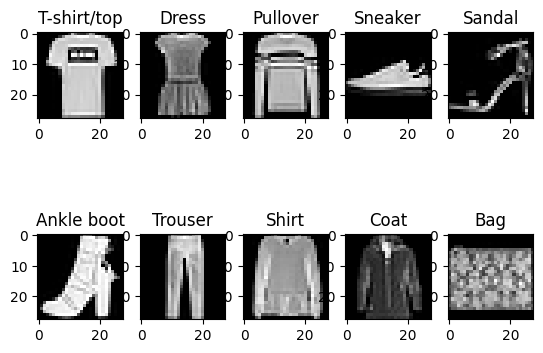

In [18]:
# Display few images

import matplotlib.pyplot as plt

cnt = 0
label_display_name = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
label = []

for i in range(1, trainX.shape[0]):

    if trainY[i] not in label:
        cnt = cnt + 1
        label.append(trainY[i])
        plt.subplot(2, 5, cnt)
        # Insert ith image with the color map 'grap'
        plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
        plt.title(label_display_name[trainY[i]])

    if cnt == 10:
        break

# Display the entire plot
plt.show()

In [11]:
## Training the model
X = trainx
Y = trainy
epochs = 10
num_of_hidden_layers = 3
size_of_layers = 128
learning_rate = 0.001
optimizer = "nadam"
batch_size = 150
l2_regularization_constant = 0
weight_init_type = "xavier"
activation_function = "tanh"
beta = 0.9
beta1 = 0.999
epsilon = 0.0001
loss_type = "mse"



Weights, Biases = train_model(
                        X=X,
                        Y=Y,
                        epochs=epochs,
                        num_of_hidden_layers=num_of_hidden_layers,
                        size_of_layers=size_of_layers,
                        learning_rate=learning_rate,
                        optimizer=optimizer,
                        batch_size=batch_size,
                        l2_regularization_constant=l2_regularization_constant,
                        weight_init_type=weight_init_type,
                        activation_function=activation_function,
                        beta=beta,
                        beta1=beta1,
                        epsilon=epsilon
                    )

Y_predict_test = validate_n(testx,Weights,Biases,activation_function)
print("accuracy test : ",get_accuracy(testy,Y_predict_test ))

number of training datapoints: 54000
number of epochs: 10
number of hidden layers: 3
size of hidden layers: 128
learning rate: 0.001
optimizer: nadam
batch_size: 150
l2 regularization constant: 0
weights and biases initialization type: xavier
activation function: tanh
beta1: 0.9
beta2: 0.999
epsilon: 0.0001
Epoch number 1  started


100%|██████████| 360/360 [00:16<00:00, 21.94it/s]


Epoch  1  finished.
total data points in validation  6000
total data points in validation  54000
training accuracy after epoch  1 : 86.71111111111112 %
training Loss (cross entropy) 0.3707198013963401
validation accuracy after epoch  1 : 85.95 %
Validation Loss (cross entropy) 0.385582225263922
Epoch number 2  started


100%|██████████| 360/360 [00:15<00:00, 23.25it/s]


Epoch  2  finished.
total data points in validation  6000
total data points in validation  54000
training accuracy after epoch  2 : 88.41111111111111 %
training Loss (cross entropy) 0.3232908629101718
validation accuracy after epoch  2 : 87.01666666666667 %
Validation Loss (cross entropy) 0.3514435714228988
Epoch number 3  started


100%|██████████| 360/360 [00:15<00:00, 23.29it/s]


Epoch  3  finished.
total data points in validation  6000
total data points in validation  54000
training accuracy after epoch  3 : 89.39814814814815 %
training Loss (cross entropy) 0.29465428874174
validation accuracy after epoch  3 : 87.71666666666667 %
Validation Loss (cross entropy) 0.33428496322900664
Epoch number 4  started


100%|██████████| 360/360 [00:15<00:00, 23.31it/s]


Epoch  4  finished.
total data points in validation  6000
total data points in validation  54000
training accuracy after epoch  4 : 90.03148148148148 %
training Loss (cross entropy) 0.27524526789853077
validation accuracy after epoch  4 : 88.03333333333333 %
Validation Loss (cross entropy) 0.3250927100704754
Epoch number 5  started


100%|██████████| 360/360 [00:15<00:00, 23.42it/s]


Epoch  5  finished.
total data points in validation  6000
total data points in validation  54000
training accuracy after epoch  5 : 90.5074074074074 %
training Loss (cross entropy) 0.2601655933993187
validation accuracy after epoch  5 : 88.44999999999999 %
Validation Loss (cross entropy) 0.3200253224489601
Epoch number 6  started


100%|██████████| 360/360 [00:15<00:00, 23.35it/s]


Epoch  6  finished.
total data points in validation  6000
total data points in validation  54000
training accuracy after epoch  6 : 90.90925925925926 %
training Loss (cross entropy) 0.2473470065347813
validation accuracy after epoch  6 : 88.64999999999999 %
Validation Loss (cross entropy) 0.31767336357207965
Epoch number 7  started


100%|██████████| 360/360 [00:16<00:00, 21.33it/s]


Epoch  7  finished.
total data points in validation  6000
total data points in validation  54000
training accuracy after epoch  7 : 91.23518518518519 %
training Loss (cross entropy) 0.23679121235659598
validation accuracy after epoch  7 : 88.76666666666667 %
Validation Loss (cross entropy) 0.3174655739398313
Epoch number 8  started


100%|██████████| 360/360 [00:15<00:00, 23.31it/s]


Epoch  8  finished.
total data points in validation  6000
total data points in validation  54000
training accuracy after epoch  8 : 91.57037037037037 %
training Loss (cross entropy) 0.22762867754601596
validation accuracy after epoch  8 : 88.78333333333333 %
Validation Loss (cross entropy) 0.31817764791790487
Epoch number 9  started


100%|██████████| 360/360 [00:15<00:00, 23.33it/s]


Epoch  9  finished.
total data points in validation  6000
total data points in validation  54000
training accuracy after epoch  9 : 91.82407407407408 %
training Loss (cross entropy) 0.220151720216614
validation accuracy after epoch  9 : 88.85 %
Validation Loss (cross entropy) 0.32042940272429554
Epoch number 10  started


100%|██████████| 360/360 [00:15<00:00, 23.32it/s]


Epoch  10  finished.
total data points in validation  6000
total data points in validation  54000
training accuracy after epoch  10 : 92.1037037037037 %
training Loss (cross entropy) 0.21343413683699403
validation accuracy after epoch  10 : 88.94999999999999 %
Validation Loss (cross entropy) 0.32389349700408654
total data points in validation  10000
accuracy test :  88.17


In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.5/263.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.3 MB/s eta 0:00:00


In [2]:
import wandb

In [3]:
wandb.login(key='8506a95d562352ae82e224bf1d33b8cdf34c0c0e')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [20]:
def main():
    wandb.init(project='DL_Assignment_1')
    config=wandb.config
    X = trainx
    Y = trainy
    epochs = config.epochs
    num_of_hidden_layers = config.num_of_hidden_layer
    size_of_layers = config.size_of_layer
    learning_rate = config.learning_rate
    optimizer = config.optimizer
    batch_size = config.batch_size
    l2_regularization_constant = config.l2_reg_constant
    weight_init_type = config.weight_init_type
    activation_function = config.activation_function
    beta = 0.9
    beta1 = 0.999
    epsilon = 0.0001
    loss_type = config.loss_type # take from command line argument

    Weights, Biases = train_model(
                        X=X,
                        Y=Y,
                        epochs=epochs,
                        num_of_hidden_layers=num_of_hidden_layers,
                        size_of_layers=size_of_layers,
                        learning_rate=learning_rate,
                        optimizer=optimizer,
                        batch_size=batch_size,
                        l2_regularization_constant=l2_regularization_constant,
                        weight_init_type=weight_init_type,
                        activation_function=activation_function,
                        beta=beta,
                        beta1=beta1,
                        epsilon=epsilon,
                        loss_type=loss_type
                    )


# Define the sweep configuration
sweep_config_old = {
    'method': 'bayes',
    'name' : 'Accuracy per Epoch',
    'metric': {
      'name': 'validation_accuracy',
      'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {
            'values': [0.001, 0.005]
        },
        'activation_function': {
            'values': ['sigmoid']
        },
        'batch_size': {
            'values': [50]
        },
        'epochs': {
            'values': [5]
        },
        'num_of_hidden_layer': {
            'values': [4]
        },
        'size_of_layer': {
            'values': [32]
        },
        'optimizer': {
            'values': ['mbgd']
        },
        'weight_init_type': {
            'values': ['random','xavier']
        },
        'l2_reg_constant': {
            'values' : [0.0005]
        }
    }
}
sweep_config = {
    'method': 'bayes',
    'name' : 'Mean_Squared_Error',
    'metric': {
      'name': 'validation_accuracy',
      'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {
            'values': [0.1, 0.01, 0.001, 0.0001, 0.00001]
        },
        'activation_function': {
            'values': ['sigmoid', 'relu', 'tanh']
        },
        'batch_size': {
            'values': [25, 50, 100, 150, 200]
        },
        'epochs': {
            'values': [5, 10]
        },
        'num_of_hidden_layer': {
            'values': [3, 4, 5]
        },
        'size_of_layer': {
            'values': [32, 64, 128]
        },
        'optimizer': {
            'values': ['sgd', 'mbgd', 'nagd', 'rmsprop', 'adam', 'nadam']
        },
        'weight_init_type': {
            'values': ['random', 'xavier']
        },
        'l2_reg_constant': {
            'values' : [0, 0.0005, 0.5]
        },
        'loss_type': {
            'values' : ["mse"]
        }
    }
}


sweep_id = wandb.sweep(sweep=sweep_config, project='DL_Assignment_1')

wandb.agent(sweep_id, function=main, count = 1)

wandb.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: t112qskd
Sweep URL: https://wandb.ai/cs23m025_dl_assignment_1/DL_Assignment_1/sweeps/t112qskd


wandb: Agent Starting Run: 9sfg4gri with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 150
wandb: 	epochs: 10
wandb: 	l2_reg_constant: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mse
wandb: 	num_of_hidden_layer: 3
wandb: 	optimizer: nagd
wandb: 	size_of_layer: 64
wandb: 	weight_init_type: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


run name = nagd_lr0.0001_bs150_hl3_hlsize64_tanh_random_epochs10_mse
number of training datapoints: 54000
number of epochs: 10
number of hidden layers: 3
size of hidden layers: 64
learning rate: 0.0001
optimizer: nagd
batch_size: 150
l2 regularization constant: 0.5
weights and biases initialization type: random
activation function: tanh
beta1: 0.9
beta2: 0.999
epsilon: 0.0001
Epoch number 1  started


100%|██████████| 360/360 [00:08<00:00, 41.71it/s]


Epoch  1  finished.
total data points in validation  6000
total data points in validation  54000
training accuracy after epoch  1 : 73.12592592592593 %
training Loss (cross entropy) 0.04012782588249353
validation accuracy after epoch  1 : 74.23333333333333 %
Validation Loss ( mse ) :  0.04012782588249353
Epoch number 2  started


100%|██████████| 360/360 [00:08<00:00, 42.57it/s]


Epoch  2  finished.
total data points in validation  6000
total data points in validation  54000
training accuracy after epoch  2 : 78.28148148148148 %
training Loss (cross entropy) 0.03138159631404697
validation accuracy after epoch  2 : 78.83333333333333 %
Validation Loss ( mse ) :  0.03138159631404697
Epoch number 3  started


100%|██████████| 360/360 [00:07<00:00, 48.20it/s]


Epoch  3  finished.
total data points in validation  6000
total data points in validation  54000
training accuracy after epoch  3 : 80.82222222222222 %
training Loss (cross entropy) 0.028139092866153643
validation accuracy after epoch  3 : 80.83333333333333 %
Validation Loss ( mse ) :  0.028139092866153643
Epoch number 4  started


100%|██████████| 360/360 [00:08<00:00, 43.11it/s]


Epoch  4  finished.
total data points in validation  6000
total data points in validation  54000
training accuracy after epoch  4 : 82.1037037037037 %
training Loss (cross entropy) 0.026356370272962906
validation accuracy after epoch  4 : 81.86666666666666 %
Validation Loss ( mse ) :  0.026356370272962906
Epoch number 5  started


100%|██████████| 360/360 [00:09<00:00, 39.64it/s]


Epoch  5  finished.
total data points in validation  6000
total data points in validation  54000
training accuracy after epoch  5 : 83.04444444444444 %
training Loss (cross entropy) 0.025214181327312415
validation accuracy after epoch  5 : 82.51666666666667 %
Validation Loss ( mse ) :  0.025214181327312415
Epoch number 6  started


100%|██████████| 360/360 [00:08<00:00, 40.10it/s]


Epoch  6  finished.
total data points in validation  6000
total data points in validation  54000
training accuracy after epoch  6 : 83.7 %
training Loss (cross entropy) 0.024393056275252248
validation accuracy after epoch  6 : 83.16666666666667 %
Validation Loss ( mse ) :  0.024393056275252248
Epoch number 7  started


100%|██████████| 360/360 [00:09<00:00, 39.70it/s]


Epoch  7  finished.
total data points in validation  6000
total data points in validation  54000
training accuracy after epoch  7 : 84.2925925925926 %
training Loss (cross entropy) 0.023706150354364713
validation accuracy after epoch  7 : 83.7 %
Validation Loss ( mse ) :  0.023706150354364713
Epoch number 8  started


100%|██████████| 360/360 [00:08<00:00, 44.41it/s]


Epoch  8  finished.
total data points in validation  6000
total data points in validation  54000
training accuracy after epoch  8 : 84.74814814814815 %
training Loss (cross entropy) 0.02313351896123026
validation accuracy after epoch  8 : 83.91666666666666 %
Validation Loss ( mse ) :  0.02313351896123026
Epoch number 9  started


100%|██████████| 360/360 [00:07<00:00, 46.03it/s]


Epoch  9  finished.
total data points in validation  6000
total data points in validation  54000
training accuracy after epoch  9 : 85.17222222222223 %
training Loss (cross entropy) 0.022643317779048648
validation accuracy after epoch  9 : 84.2 %
Validation Loss ( mse ) :  0.022643317779048648
Epoch number 10  started


100%|██████████| 360/360 [00:07<00:00, 46.90it/s]


Epoch  10  finished.
total data points in validation  6000
total data points in validation  54000
training accuracy after epoch  10 : 85.55 %
training Loss (cross entropy) 0.022216714698408163
validation accuracy after epoch  10 : 84.51666666666667 %
Validation Loss ( mse ) :  0.022216714698408163


epoch_number,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▇▇▇███
training_loss,█▅▃▃▂▂▂▁▁▁
validation_accuracy,▁▄▅▆▇▇▇███
validation_loss,█▅▃▃▂▂▂▁▁▁
epoch_number,10
training_accuracy,85.55
training_loss,0.02222
validation_accuracy,84.51667
validation_loss,0.02222
